In [1]:
import cv2
import matplotlib.pyplot as plt
import pytesseract
import numpy as np
from utils import *
pytesseract.pytesseract.tesseract_cmd = r'E:\Downloads\Tesseract OCR\tesseract.exe'



    
         

8 Crsh Fe

SubTotal 5.98
an 4
Total 161
cst oocovxz07

 

i Aoproval

ORIVE THRU
aie i

nank

MOBILE
ORDERING

ij IS HERE

 

S$. | ove NO Am



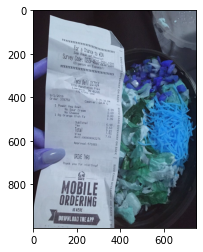

In [17]:

img = cv2.imread(path)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
#img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
# Performing OTSU threshold 
#ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV) 
  
# Specify structure shape and kernel size.  
# Kernel size increases or decreases the area  
# of the rectangle to be detected. 
# A smaller value like (10, 10) will detect  
# each word instead of a sentence. 
#rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (18, 18)) 
  
# Appplying dilation on the threshold image 
#dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1) 
  
# Finding contours 
#
# contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE) 
plt.imshow(img)
text = pytesseract.image_to_string(img) 
print(text)